Estudio de distribución de distancias de los exoplanetas a su estrella

-----------

El código usa un query similar al del problema 6 para traer los valores del semieje mayor (no dice si es relativo, baricéntrico o de Jacobi) y luego intentar ver si una gaussiana puede explicar su distribución

Primero busco cuál es ma gaussiana que mejor representa los datos usando el algorítmo genético como minimizador del estadístico Chi2, y luego comparo ambas distribuciones con el ks-test de scipy

In [1]:
%matplotlib inline 
import numpy as np 
import matplotlib.pyplot as plt
import pyvo
from astropy.visualization import hist
from scipy.stats import norm, kstest
# Estilo de gráficos
plt.style.use('dark_background')
# Servicio pyvo
service = pyvo.dal.TAPService("http://voparis-tap-planeto.obspm.fr/tap");

In /home/matt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/matt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/matt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/matt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/matt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-d

In [2]:
query = """SELECT semi_major_axis, semi_major_axis_error_min, semi_major_axis_error_max
FROM exoplanet.epn_core
WHERE mass<15 AND period>0 AND star_distance>0 AND semi_major_axis>0
AND semi_major_axis_error_min>0 AND semi_major_axis_error_max>0"""
res = service.search(query);

In [3]:
# Obtengo los valores de las columnas en listas con un loop
Sma = [] # Semieje mayor 
Errmin = [] # Error por izquierda del semieje mayor
Errmax = [] # Error por derecha del semieje mayor
ij = 0
while ij < len(res):
    Sma.append( res.getvalue(name='semi_major_axis', index=ij) )
    Errmin.append( res.getvalue(name='semi_major_axis_error_min', index=ij) )
    Errmax.append( res.getvalue(name='semi_major_axis_error_max', index=ij) )
    ij = ij + 1
    
# Ordeno los valores de Sma y creo "Esc": distribución "escalón acumulada"
Indices = np.argsort(Sma) # Guardo los índices originales para luego armar ERR
Sma = np.sort(Sma) 
Esc = []
ij = 0
while ij<len(Sma):
    Esc.append( ij/len(Sma) )
    ij = ij + 1
    
# Calculo los errores simétricos usando el máximo
ERR = []
for ij in Indices:
    ERR.append(max(Errmin[ij], Errmax[ij]))  
    ij = ij + 1

El modelo a ajustar será el de una gaussiana, para eso usaré scipy y sus métodos

In [4]:
# Defino el estadístico a minimizar (Chi2)
def Chi2(Params):
    """ Devuelve el valor del estadístico Chi2
    
    Parameters
    ----------
    Params : list
        Lista con los parámetros a ajustar del modelo
        
    Retuns
    ------
    Chi2 : .float
        Valor de Chi2
    
    """
    import numpy as np
    from scipy.stats import norm
    mu, std = Params
    
    N = len(Sma)
    # Mis observaciones 
    Obs = Esc
    # Construyo las "observaciones" teóricas (con scipy)
    rv = norm(loc=mu, scale=std)
    Calc = rv.cdf(Sma) # Obs. teóricas
                
    Chi2 = (1/N)*np.sum( ( (Obs-Calc)/ERR )**2. )
    return Chi2

In [5]:
# Bounds para la exploración con algoritmo genético:
rmu = (0.01, 0.1) # Rango de valores de "mu", cualitativos                    
rstd = (0.001, 1) # Rango de valores de "std", cualitativos

In [6]:
%%time
# Corro el algorítmo genético
import scipy.optimize as optimize
bounds = (rmu, rstd)
resAG = optimize.differential_evolution(Chi2, bounds, strategy='best1bin', 
                                           maxiter=1000, popsize=100,tol=0.001, 
                                           mutation=(0.5, 1), recombination=0.7, 
                                           seed=None, callback=None, disp=False, 
                                           polish=True, init='latinhypercube', atol=0)

CPU times: user 7.77 s, sys: 22.6 ms, total: 7.79 s
Wall time: 7.9 s


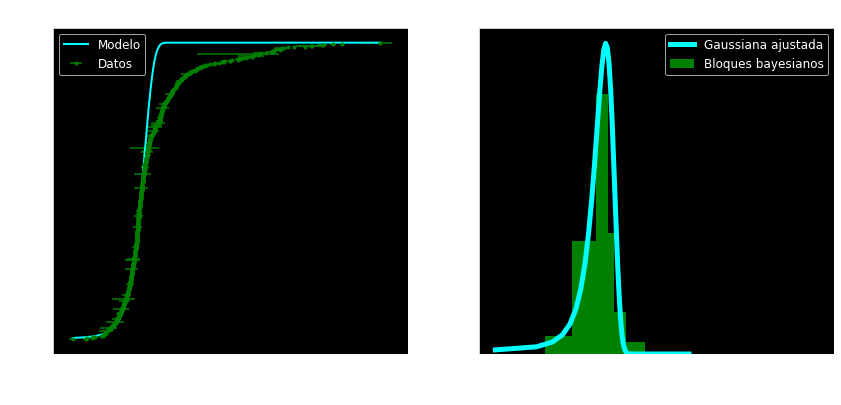

In [7]:
# Grafico los resultados para comparar cualitativamente primero
fig, ax = plt.subplots(1, 2, figsize = (14,6))

rv = norm( resAG.x[0], resAG.x[1] )
x = np.linspace(0.001, 1, 300)

ax[0].errorbar(Sma, Esc, xerr=ERR, color='green', label='Datos', zorder=2, fmt='.')
ax[0].plot(Sma, rv.cdf(Sma), color='cyan', label='Modelo', lw=2)


ax[1].plot(x, rv.pdf(x), color='cyan', lw=5, label='Gaussiana ajustada', zorder=3)
hist(Sma, bins='blocks', ax=ax[1], density=True, color='green', label='Bloques bayesianos',
    zorder=2)

ax[0].set_title('Dist. de probabilidad acumulada', fontsize=20)
ax[0].set_xlabel('Distancia [UA]', fontsize=20)
ax[0].set_ylabel('Frecuencia', fontsize=20)
ax[0].set_xscale('log')
ax[0].legend(fontsize=12)

ax[1].set_title('Histograma de distancias', fontsize=20)
ax[1].set_xlabel('Distancia [UA]', fontsize=20)
ax[1].set_ylabel('Frecuencia', fontsize=20)
ax[1].set_xscale('log')
ax[1].legend(fontsize=12);

Hago el KS-Test

In [8]:
Test = kstest(Esc, rv.cdf(Sma))
print('Distancia máxima:', round(Test[0], 2))
# El p-value es Test[1]
print('p-value:', Test[1])

Distancia máxima: 0.26
p-value: 2.871670340523641e-18


Como se observa, el p-value es muy chico, no importa qué nivel de significancia razonable pida ( ~80%, 90%, 95%, 99%, 99,99%, etc) se rechaza la hipótesis nula (que las distribuciones son iguales).

Se concluye que la gaussiana **NO** representa a los datos porque siempre p<alpha